In [1]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dense,Activation,Dropout,Flatten,ZeroPadding2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [2]:
input_shape = (224, 224, 3)
img_width=224
img_height=224
batch_size=10
epocs=20

In [3]:
# !pip install split-folders

Splitting data into test, train and validation datasets

In [4]:
# import splitfolders 
# input_folder = './tumor_dataset/dataset'
# output_folder = './tumor_dataset/data'
# splitfolders.ratio(input_folder,output=output_folder,
#                   seed=42,ratio=(0.7,0.2,0.1),
#                   group_prefix=None)

In [5]:
train_data_dir="./tumor_dataset/data/train"
validation_data_dir="./tumor_dataset/data/val"
test_data_dir="./tumor_dataset/data/test"

creating dataset generator and augmentation function

In [6]:
validation_datagen=ImageDataGenerator(
    rescale=1./255
)



train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2
)

In [7]:
#preprocessing the data using train and validation data generator 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode ='categorical',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

test_generator = validation_datagen.flow_from_directory(
        test_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 305 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import VGG19

# MobileNet was designed to work on 224 x 224 pixel input images sizes


# Re-loads the MobileNet model without the top or FC layers
VGG19 = VGG19(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in VGG19.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(VGG19.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


In [9]:
from tensorflow.keras.layers import GlobalMaxPool2D
def addTopinception(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    topmodel= BatchNormalization()(top_model)
    top_model = GlobalMaxPool2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [10]:
from tensorflow.keras.models import Model

# Set our class number to 3 (Young, Middle, Old)
num_classes = 2

FC_Head = addTopinception(VGG19, num_classes)

model = Model(inputs = VGG19.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# initiate RMSprop optimizer and configure some parameters
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("newVGG.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,  #Abs value and is the main change required before we stop
                          patience = 5, #no of epocs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keep the best weigts once stopped

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.001,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [12]:
model.compile(loss = 'categorical_crossentropy',
        optimizer = RMSprop(lr = 0.001),
        metrics = ['accuracy'])

C:\annaconda\envs\tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
train = model.fit_generator(
    train_generator,
    steps_per_epoch =2100 // batch_size,
    epochs = 200,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 600 // batch_size)

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
210/210 [==============================] - 31s 126ms/step - loss: 0.7494 - accuracy: 0.6357 - val_loss: 0.4720 - val_accuracy: 0.7933

Epoch 00001: val_loss improved from inf to 0.47201, saving model to newVGG.h5
Epoch 2/200
210/210 [==============================] - 27s 131ms/step - loss: 0.5689 - accuracy: 0.7367 - val_loss: 0.4036 - val_accuracy: 0.8217

Epoch 00002: val_loss improved from 0.47201 to 0.40363, saving model to newVGG.h5
Epoch 3/200
210/210 [==============================] - 33s 158ms/step - loss: 0.4910 - accuracy: 0.7671 - val_loss: 0.3697 - val_accuracy: 0.8467

Epoch 00003: val_loss improved from 0.40363 to 0.36967, saving model to newVGG.h5
Epoch 4/200
210/210 [==============================] - 34s 159ms/step - loss: 0.4832 - accuracy: 0.7867 - val_loss: 0.3902 - val_accuracy: 0.8283

Epoch 00004: val_loss did not improve from 0.36967
Epoch 5/200
210/210 [==============================] - 29s 140ms/step - loss: 0.4610 - accuracy: 0.7833 - val_loss: 0.3

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[90 62]
 [61 92]]


array([61, 92], dtype=int64)

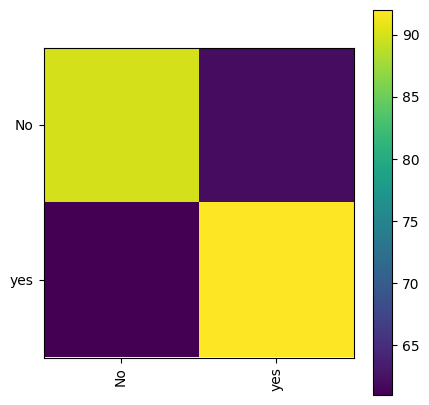

In [14]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

img_row, img_height, img_depth = 150,150,3


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 2100
nb_validation_samples = 600
nb_test_samples=305

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(5,5))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)
print(cnf_matrix)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
a=cnf_matrix[1]
a

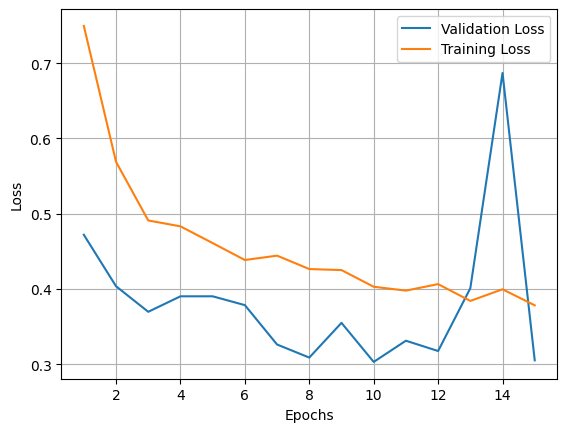

In [15]:
# Plotting our loss charts
import matplotlib.pyplot as plt
epochs=34
history_dict = train.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

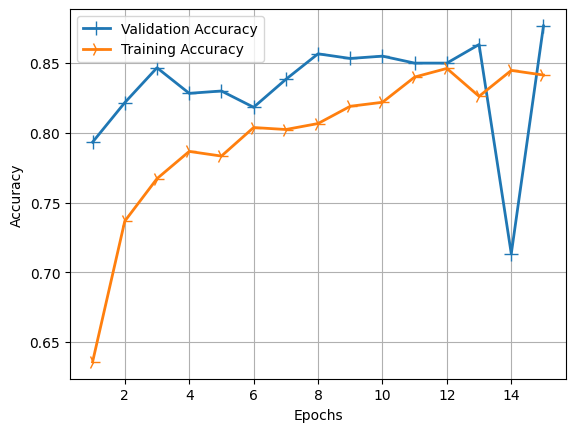

In [16]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = train.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

(1, 224, 224, 3)
[[0. 1.]]
The category =  Tumor


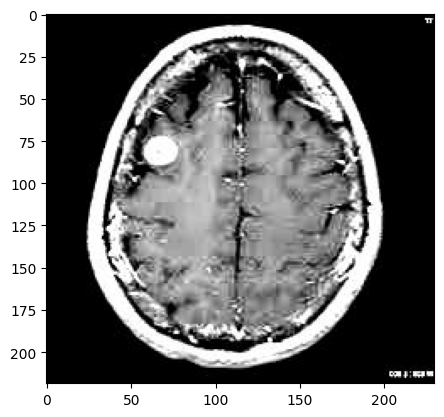

In [20]:
#testing the model on datas from test dataset

import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

d = {0:'No tumor',1:'Tumor'}
input_shape = (224, 224, 3)
image_path = './tumor_dataset/data/test/yes/y31.jpg'
model = models.load_model('newVGG.h5')
test_image = load_img(image_path,target_size = input_shape)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
print(test_image.shape)
result = model.predict(test_image)
print(result)

testImage = img.imread(image_path)
print("The category = ",d[np.argmax(result)])
# displaying the modified image
plt.imshow(testImage)

In [18]:
test_dir='./tumor_dataset/data/test'
test_gen=validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode='categorical'
)
#predicting the datasets class and value loss(Testing accuracy and loss)
model.evaluate_generator(test_gen,steps=3)


Found 305 images belonging to 2 classes.


C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.39014190435409546, 0.8333333134651184]